## IMPORTS

In [53]:
# Generales
import torch
import os
import sys
import pandapower as pp
from omegaconf import OmegaConf
import warnings
warnings.filterwarnings('ignore')

# Julia
import julia
julia.install()
from julia.api import Julia
jl = Julia(compiled_modules=False)

# Internos
sys.path.append(os.path.abspath('../entrenamiento'))
from src.arquitecturas import FCNN_global, GNN_Local
from src.Data_loader import load_net, load_data
from src.metric import NormalizedError


[ Info: Julia version info


Julia Version 1.8.1
Commit afb6c60d69a (2022-09-06 15:09 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.5 LTS
  uname: Linux 6.8.0-45-generic #45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Sep 11 15:25:05 UTC 2 x86_64 x86_64
  CPU: 13th Gen Intel(R) Core(TM) i5-13400F: 
                 speed         user         nice          sys         idle          irq
       #1-16  4092 MHz      92803 s         22 s      12738 s   30787124 s          0 s
  Memory: 62.63290023803711 GB (49860.7890625 MB free)
  Uptime: 193104.36 sec
  Load Avg:  0.74  1.23  1.13
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, goldmont)
  Threads: 1 on 16 virtual cores
Environment:
  HOME = /home/nacho
  PATH = /home/nacho/miniconda3/envs/proy/bin:/home/nacho/.vscode-server/cli/servers/Stable-384ff7382de624fb94dbaf6da11977bba1ecd427/server/bin/remote-cli:/home/nacho/.local/bin:/home/nacho/miniconda3/envs/proy/bin:/home/nacho/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/u

[ Info: Julia executable: /home/nacho/julia-1.8.1/bin/julia
[ Info: Trying to import PyCall...
┌ Warning: PyCall is already installed.  However, you may have trouble using
│ this Python executable because it is statically linked to libpython.
│ 
│ For more information, see:
│     https://pyjulia.readthedocs.io/en/latest/troubleshooting.html
│ 
│ Python executable:
│     /home/nacho/miniconda3/envs/proy/bin/python
│ Julia executable:
│     /home/nacho/julia-1.8.1/bin/julia
└ @ Main ~/miniconda3/envs/proy/lib/python3.12/site-packages/julia/install.jl:90


## Levantar Red electrica, modelo y datos

In [59]:
# Definir red
red = "uru" 
arq = "FCNN_global" # "FCNN_global" o "GNN_local"
base_path = f"./runs_sintetica/{arq}/" #  f"./runs_sintetica/{arq}/" o f"./runs/{arq}/"

# Levantar config
cfg = OmegaConf.load(base_path + 'best' + "/config.yaml")
weights_dir = base_path + 'best' +  "/weights/best_model.pt"

# Settar device
torch.manual_seed(cfg.training.seed)
device = cfg.training.device

# Levantar red electrica
num_nodes, num_gens, edge_index, edge_weights, feature_mask, min_max_values_v, min_max_values_q, net= load_net(cfg.data.red,cfg.data.red_path,device)

# Levantar data
train_loader, val_loader, test_loader, norm_X, norm_y = load_data(cfg.data.data_path, cfg.training.batch_size, cfg.data.normalize_X, cfg.data.normalize_Y,device)
train_loader_no_norm, val_loader_no_norm, test_loader_no_norm, _, _ = load_data(cfg.data.data_path, cfg.training.batch_size, False, False,device)

# Levantar red neuronal
if cfg.model.model == 'FCNN_global':
    cfg.model.layers[0] *= num_nodes
    model = FCNN_global(cfg.model.layers,len(cfg.model.layers)-1,num_nodes, feature_mask, min_max_values_v, min_max_values_q, cfg.model.dropout, cfg.model.batch_norm, norm_X, norm_y).to(device)
elif cfg.model.model == 'GNN_local':
    model = GNN_Local(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,cfg.model.K,feature_mask,num_nodes, min_max_values_v, min_max_values_q, cfg.model.dropout,cfg.model.batch_norm, norm_X, norm_y).to(device)

# Cargo los pesos
model.load_state_dict(torch.load(weights_dir))
model.eval()

FCNN_global(
  (linears): ModuleList(
    (0): Linear(in_features=428, out_features=1024, bias=True)
    (1-2): 2 x Linear(in_features=1024, out_features=1024, bias=True)
    (3): Linear(in_features=1024, out_features=214, bias=True)
  )
  (dropout): Dropout(p=0.19028171196907112, inplace=False)
  (relu): LeakyReLU(negative_slope=0.01)
)

## EVALUACIONES

### Metrica de Test

In [60]:
normalized_error = NormalizedError()
total_metric_v = 0
total_metric_q = 0
with torch.no_grad():
    for (x,y),(x_norm,y_norm) in zip(test_loader_no_norm,test_loader):
        y_pred = model(x_norm,training=False, denormalize_y=True)
        # metric_v, metric_q = normalized_error(y_pred,y)
        metric_v = torch.mean(torch.abs(y[:,:,0]-y_pred.squeeze()[:,:,0]).sum(dim=-1) / num_gens)
        metric_sh = torch.mean(torch.abs(y[:,:,1]-y_pred.squeeze()[:,:,1]).sum(dim=-1) / net.sgen['controllable'].sum())
        
        total_metric_v += metric_v.item()
        total_metric_q += metric_sh.item()

    avg_metric_v = total_metric_v / len(test_loader_no_norm)
    avg_metric_q = total_metric_q / len(test_loader_no_norm)
    print(f'[{arq}] MAE_V:', avg_metric_v)
    print(f'[{arq}] MAE_Q:', avg_metric_q)

[FCNN_global] MAE_V: 0.0004623145505320281
[FCNN_global] MAE_Q: 0.2842336632311344


## Predecir outputs

In [61]:
import numpy as np
y_tot_V = []
y_tot_sh = []
y_pred_V = []
y_pred_sh = []
x_tot = []

with torch.no_grad():
    for x,y in test_loader_no_norm:
        x_tot.append(x.detach().cpu().numpy())
        y_tot_V.append(y[:,:,0].detach().cpu().numpy())
        y_tot_sh.append(y[:,:,1].detach().cpu().numpy())

    for x,y in test_loader:
        y_pred = model(x, training=False, denormalize_y=cfg.data.normalize_Y)
        y_pred = y_pred.detach().cpu().numpy()
        y_pred_V.append(y_pred[:,:,0])
        y_pred_sh.append(y_pred[:,:,1])
        x.detach().cpu().numpy()

    # Concatenate in dim 0
    y_pred_V = np.concatenate(y_pred_V, axis=0).squeeze()
    y_pred_sh = np.concatenate(y_pred_sh, axis=0).squeeze()
    y_tot_V = np.concatenate(y_tot_V, axis=0).squeeze()
    y_tot_sh = np.concatenate(y_tot_sh, axis=0).squeeze()
    x_tot = np.concatenate(x_tot, axis=0).squeeze()

In [62]:
# Create a map from net.bus.index to the position of the bues
bus_map = {net.bus.index[i]: i for i in range(len(net.bus))}


# That also works for a list of buses
def bus_pos(buses):
    try:
        return [bus_map[bus] for bus in buses]
    except:
        return bus_map[buses]
    
idx_gens = bus_pos(net.gen.bus.values.astype(int))
idx_load = bus_pos(net.load.bus.values.astype(int))
idx_sgen = bus_pos(net.sgen[net.sgen.controllable==False].bus.values.astype(int))
idx_shunt = bus_pos(net.sgen[net.sgen.controllable==True].bus.values.astype(int))
idx_ext_grid = bus_pos(net.ext_grid.bus.values.astype(int))

### Grafiar optimo vs predicho

#### Voltajes

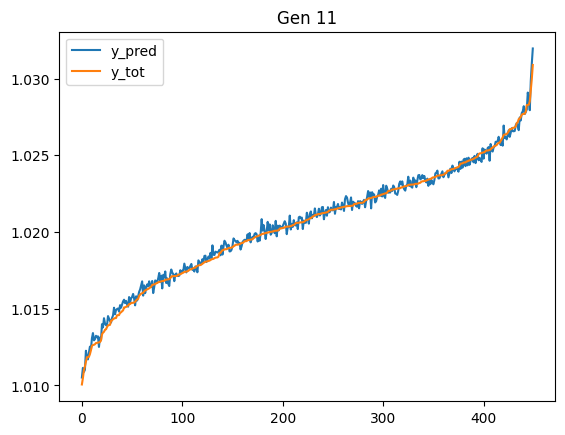

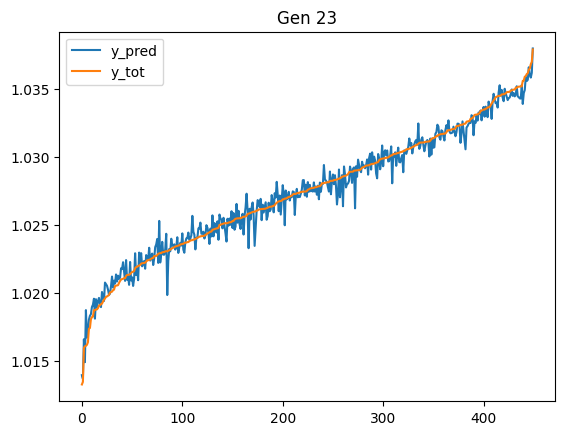

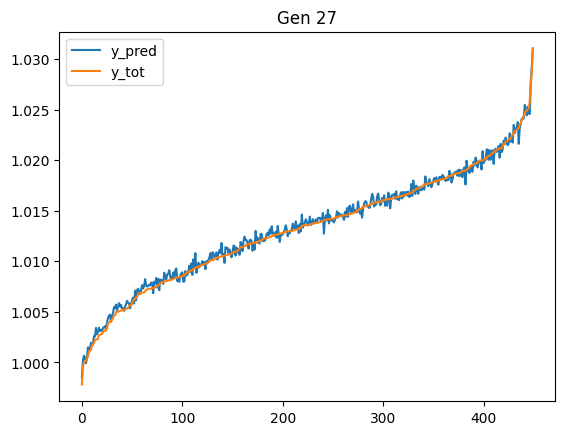

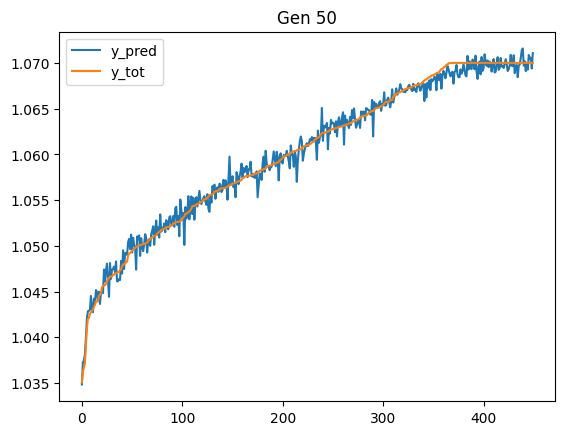

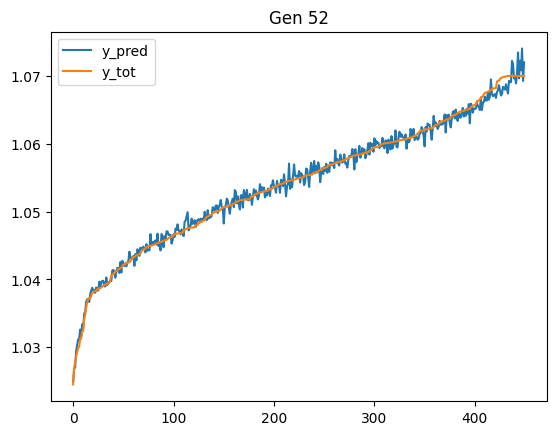

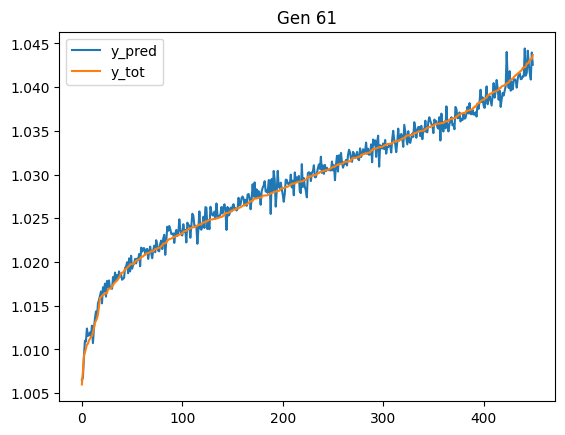

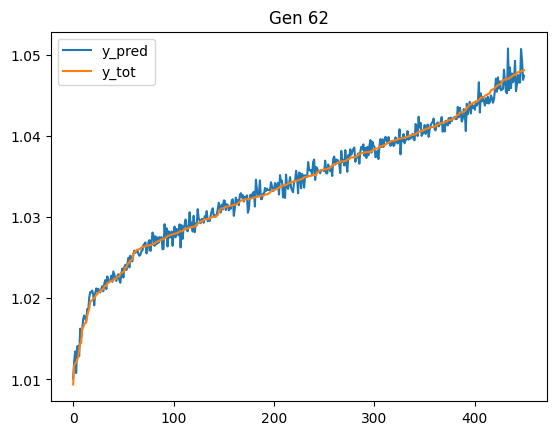

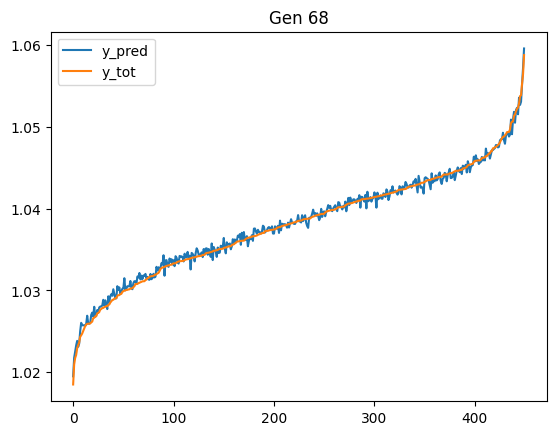

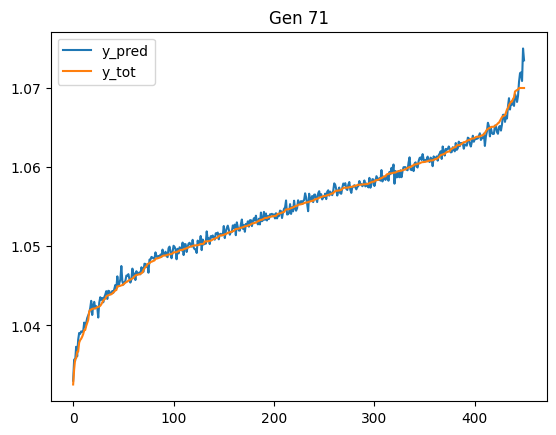

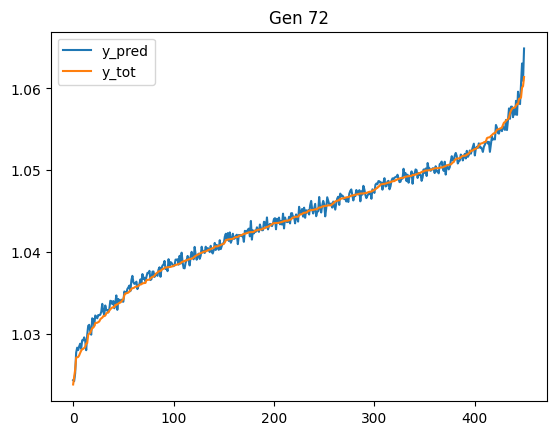

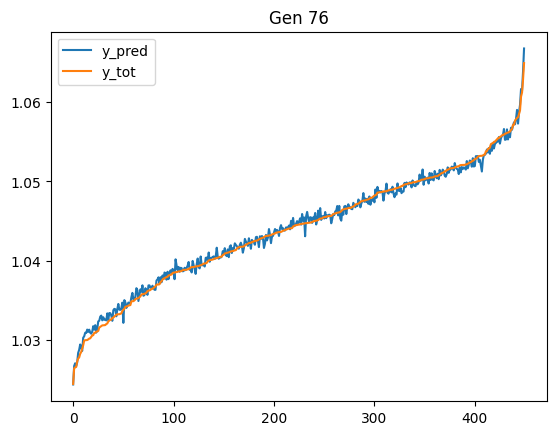

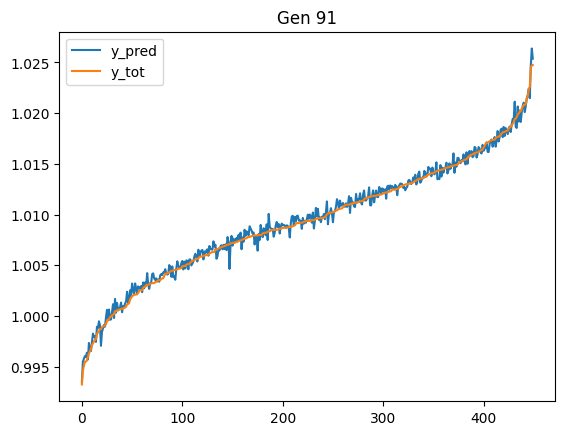

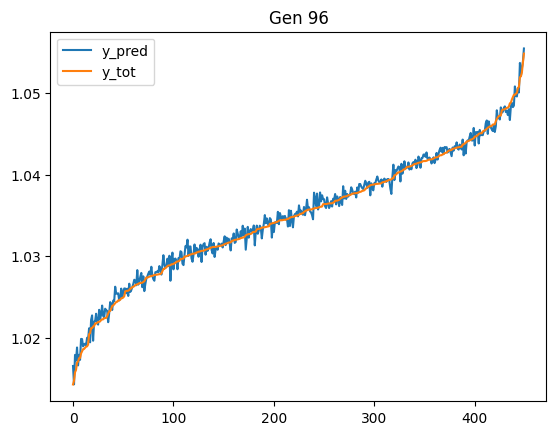

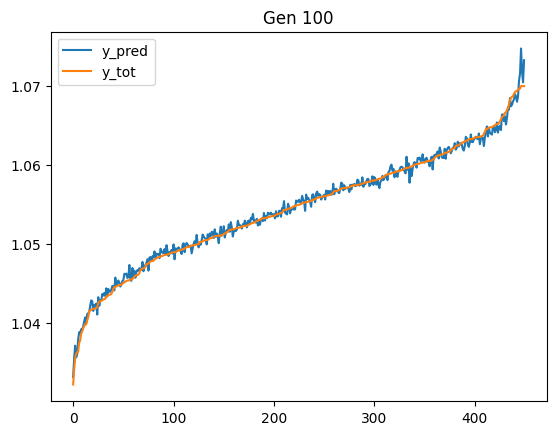

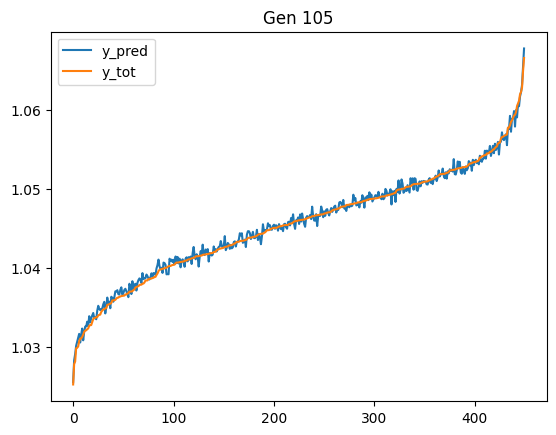

In [63]:
# Plot an histagram per gen of y_pred and y_tot
import matplotlib.pyplot as plt
for i in idx_gens:
    plt.figure()
    # order y_tot[:,i] from smallest to largest and y_pred[:,i] witj same order
    idx = np.argsort(y_tot_V[:,i].squeeze())
    y_tot_i = y_tot_V[idx,i].squeeze()
    y_pred_i = y_pred_V[idx,i].squeeze()
    plt.plot(y_pred_i, label='y_pred')
    plt.plot(y_tot_i, label='y_tot')
    plt.title(f"Gen {i}")
    plt.legend()
    plt.show()


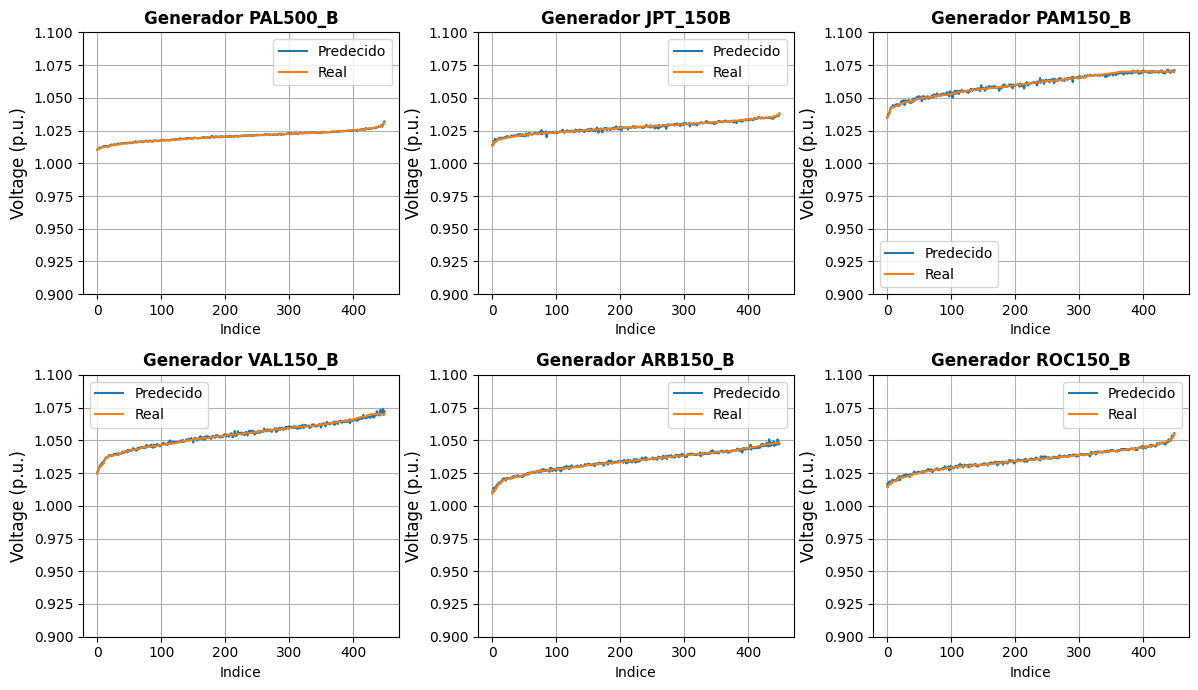

In [64]:
ids = [0,1,3,4,6,12]

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,3, figsize=(12,7))
for ind,i in enumerate([idx for j,idx in enumerate(idx_gens) if j in ids]):
    
    idx = np.argsort(y_tot_V[:,i].squeeze())
    y_tot_i = y_tot_V[idx,i].squeeze()
    y_pred_i = y_pred_V[idx,i].squeeze()
    
    row = (ind)//3
    col = (ind)%3
    
    axs[row,col].plot(y_pred_i, label='Predecido')
    axs[row,col].plot(y_tot_i, label='Real')
    axs[row,col].set_title(f"Generador {net.bus.iloc[i]['name']}", fontweight='bold')
    axs[row,col].set_ylim(0.9,1.1)
    # set y and x title
    axs[row,col].set_ylabel("Voltage (p.u.)", fontsize=12)
    axs[row,col].set_xlabel("Indice")
    axs[row,col].legend()
    axs[row,col].grid()
# delete last plot
plt.tight_layout()
plt.show()


### Shunts

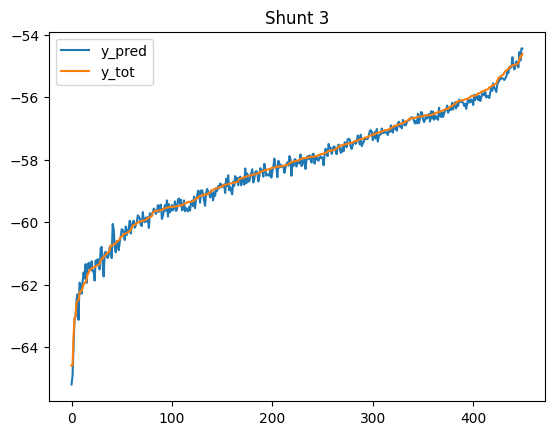

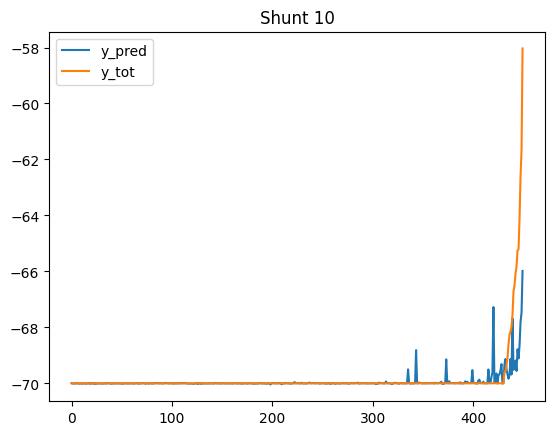

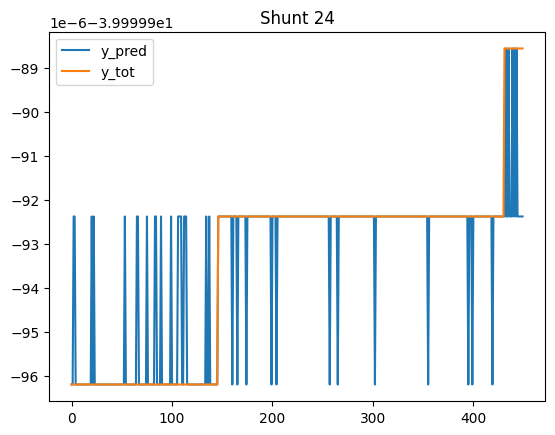

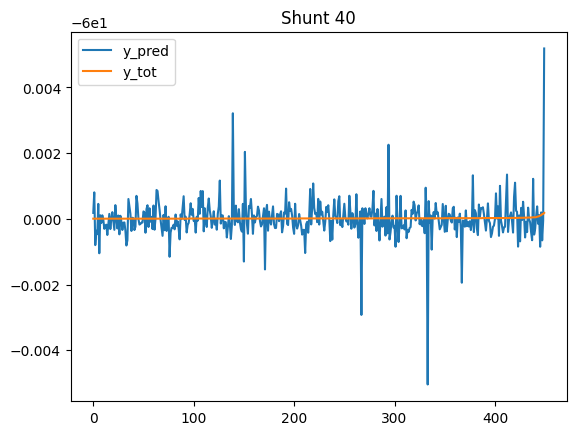

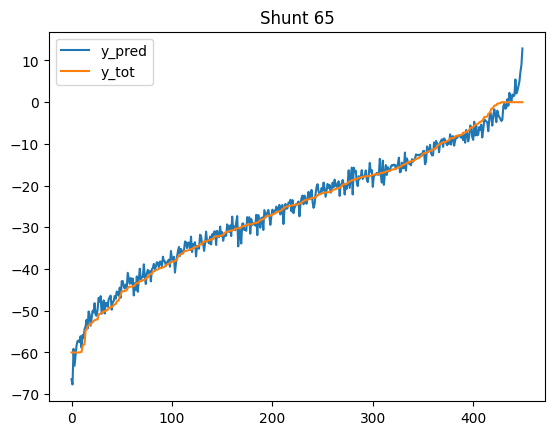

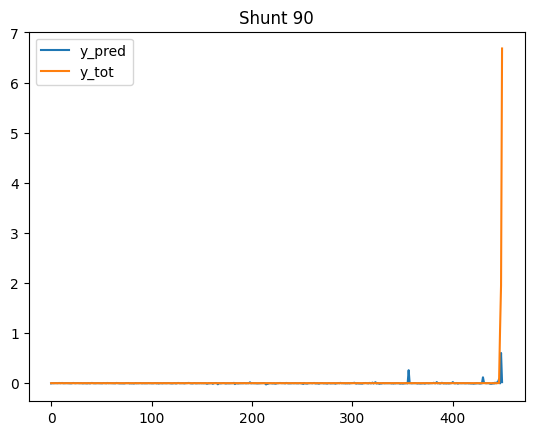

In [65]:
# Plot an histagram per gen of y_pred and y_tot
import matplotlib.pyplot as plt
for i in idx_shunt:
    plt.figure()
    idx = np.argsort(y_tot_sh[:,i].squeeze())
    y_tot_i = y_tot_sh[idx,i].squeeze()
    y_pred_i = y_pred_sh[idx,i].squeeze()
    plt.plot(y_pred_i, label='y_pred')
    plt.plot(y_tot_i, label='y_tot')
    plt.title(f"Shunt {i}")
    plt.legend()
    plt.show()

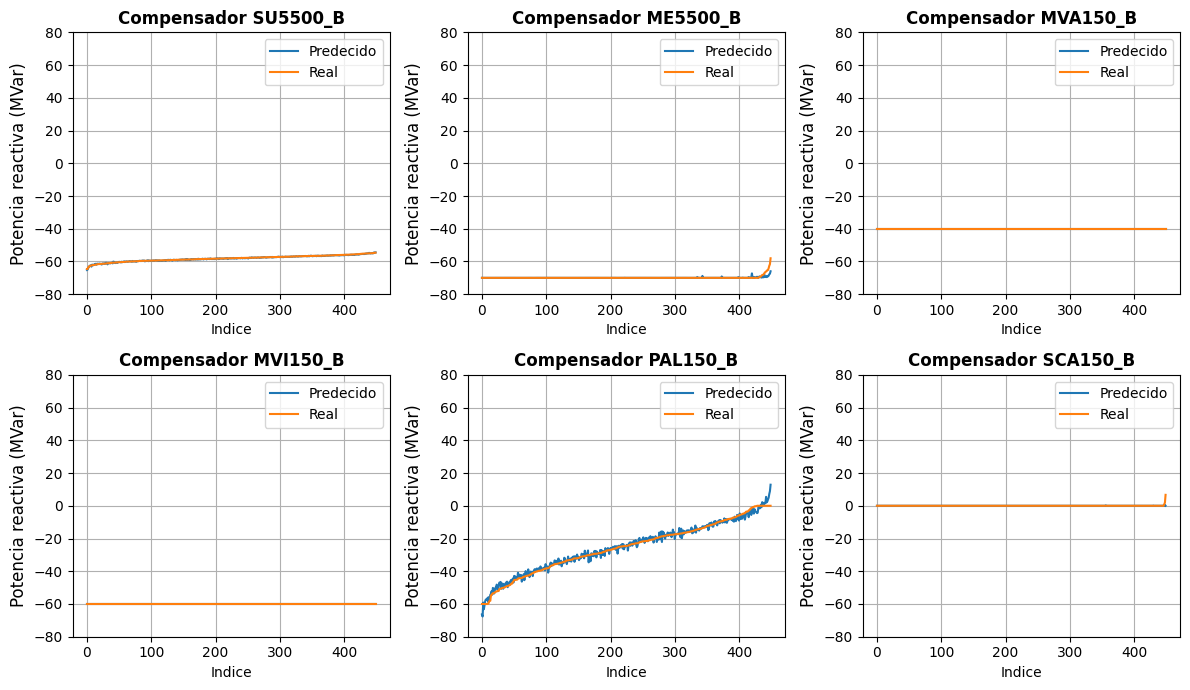

In [66]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,3, figsize=(12,7))
for ind,i in enumerate(idx_shunt):
    
    idx = np.argsort(y_tot_sh[:,i].squeeze())
    y_tot_i = y_tot_sh[idx,i].squeeze()
    y_pred_i = y_pred_sh[idx,i].squeeze()
    
    row = (ind)//3
    col = (ind)%3
    
    axs[row,col].plot(y_pred_i, label='Predecido')
    axs[row,col].plot(y_tot_i, label='Real')
    axs[row,col].set_title(f"Compensador {net.bus.iloc[i]['name']}", fontweight='bold')
    axs[row,col].set_ylim(-80,80)
    # set y and x title
    axs[row,col].set_ylabel("Potencia reactiva (MVar)", fontsize=12)
    axs[row,col].set_xlabel("Indice")
    axs[row,col].legend()
    axs[row,col].grid()
# delete last plot
plt.tight_layout()
plt.show()


## Evaluar desempeño como solucion del ORPD

### Función para evaluar pérdias y unfeasiblity

In [69]:

def get_stats(net,tol=1e-3, percent_gap=None):

    # METRICA
    Y_line_ij = np.asarray(net._ppc["internal"]["Yf"].todense())
    Y_line_ji = np.asarray(net._ppc["internal"]["Yt"].todense())
    V_mag = net.res_bus.vm_pu
    delta = net.res_bus.va_degree
    V = V_mag * np.exp(1j * delta * 2*np.pi/360)
    V_lines_to = [V[x] for x in net.line.to_bus] + [V[x] for x in net.trafo.lv_bus]
    V_lines_from = [V[x] for x in net.line.from_bus] + [V[x] for x in net.trafo.hv_bus]
    ploss = (V_lines_from * np.conj(np.matmul(Y_line_ij,V)) + V_lines_to * np.conj(np.matmul(Y_line_ji,V))).real * net.sn_mva
    ploss_cost = ploss.sum()
    
    # UNFEASIBILITIES
    
    ## Lineas
    max_line = net.line.max_loading_percent.values.copy()
    if percent_gap is not None:
        max_line = max_line * (1 + percent_gap)
    unfeas_line = (net.res_line.loading_percent.values > max_line + tol).sum()
    gap_line_max = (net.res_line.loading_percent.values - net.line.max_loading_percent.values - tol)/(net.line.max_loading_percent.values - 0)
    gap_line_max = gap_line_max[np.where(gap_line_max > 0)] * 100

    ## Trafos
    unfeas_trafo = 0
    gap_trafo_max = []
    if len(net.trafo) > 0:
        max_trafo = net.trafo.max_loading_percent.values.copy()
        if percent_gap is not None:
            max_trafo = max_trafo * (1 + percent_gap)
        unfeas_trafo = (net.res_trafo.loading_percent.values > max_trafo + tol).sum()
        gap_trafo_max = (net.res_trafo.loading_percent.values - net.trafo.max_loading_percent.values - tol)/(net.trafo.max_loading_percent.values - 0)
        gap_trafo_max = gap_trafo_max[np.where(gap_trafo_max > 0)] * 100
    else:
        unfeas_trafo = 0
    
    ## Voltajes
    max_volt = net.bus.max_vm_pu.values.copy()
    min_volt = net.bus.min_vm_pu.values.copy()
    if percent_gap is not None:
        max_volt +=  percent_gap*(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
        min_volt -= percent_gap*(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    unfeas_volt = (net.res_bus.vm_pu.values < min_volt - tol).sum() + (net.res_bus.vm_pu.values > max_volt + tol).sum()
    gap_volt_max = (net.res_bus.vm_pu.values - net.bus.max_vm_pu.values - tol)/(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    gap_volt_max = gap_volt_max[np.where(gap_volt_max > 0)] * 100
    gap_volt_min = (-net.res_bus.vm_pu.values + net.bus.min_vm_pu.values + tol)/(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    gap_volt_min = gap_volt_min[np.where(gap_volt_min > 0)] * 100
    
    ## Q extGrid
    max_q_extgrid = net.ext_grid.max_q_mvar.values.astype(float).copy()
    min_q_extgrid = net.ext_grid.min_q_mvar.values.astype(float).copy()
    if percent_gap is not None:
        max_q_extgrid +=  percent_gap*(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
        min_q_extgrid -= percent_gap*(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    unfeas_q_ext_grid = (net.res_ext_grid.q_mvar.values < min_q_extgrid - tol).sum() + (net.res_ext_grid.q_mvar.values > max_q_extgrid + tol).sum()
    gap_q_ext_grid_max = (net.res_ext_grid.q_mvar.values - net.ext_grid.max_q_mvar.values - tol)/(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    gap_q_ext_grid_max = gap_q_ext_grid_max[np.where(gap_q_ext_grid_max > 0)] * 100
    gap_q_ext_grid_min = (-net.res_ext_grid.q_mvar.values + net.ext_grid.min_q_mvar.values + tol)/(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    gap_q_ext_grid_min = gap_q_ext_grid_min[np.where(gap_q_ext_grid_min > 0)] * 100

    # Juntar Todo
    gaps_percentages = []
    if len(gap_line_max) > 0:
        gaps_percentages += list(gap_line_max)
    if len(gap_trafo_max) > 0:
        gaps_percentages += list(gap_trafo_max)
    if len(gap_volt_max) > 0:
        gaps_percentages += list(gap_volt_max)
    if len(gap_volt_min) > 0:
        gaps_percentages += list(gap_volt_min)
    if len(gap_q_ext_grid_max) > 0:
        gaps_percentages += list(gap_q_ext_grid_max)
    if len(gap_q_ext_grid_min) > 0:
        gaps_percentages += list(gap_q_ext_grid_min)
        
    if unfeas_line > 0 or unfeas_trafo > 0 or unfeas_volt > 0 or unfeas_q_ext_grid > 0:
        unfeas = True
    else:
        unfeas = False
    return ploss_cost, unfeas, [unfeas_line, unfeas_trafo, unfeas_volt, unfeas_q_ext_grid], gaps_percentages

### Ejecutar la función para datos de test

In [70]:

v_cost_hist = []
unf_hist = []
unf_cont_hist = []

gap_percentages_hist_pred = []
gap_percentages_hist_opt = []
gap_percentages_hist_v1 = []

percent_gap = 0.0 # CAMBIAR POR TOLERANCIA DESEADA EN PORCENTAJE DIVIDIO 100 (0.018 datos reales, 0.00 datos sinteticos)

for idx in range(np.shape(x_tot)[0]):
    try:
        net.load.loc[:,'p_mw'] = x_tot[idx,idx_load,0]
        net.load.loc[:,'q_mvar'] = x_tot[idx,idx_load,1]
        net.gen.loc[:,'p_mw'] =  x_tot[idx,idx_gens,2]
        net.sgen.p_mw.loc[net.sgen.controllable==False] = x_tot[idx,idx_sgen,3]
        
        assert np.allclose(net.load.loc[:,'p_mw'] , x_tot[idx,idx_load,0], atol=1e-5)
        assert np.allclose(net.load.loc[:,'q_mvar'] , x_tot[idx,idx_load,1], atol=1e-5)
        assert np.allclose(net.gen.loc[:,'p_mw'] , x_tot[idx,idx_gens,2], atol=1e-5)

        net.gen.vm_pu = y_pred_V[idx,idx_gens]
        net.sgen.loc[net.sgen.controllable==True,"q_mvar"] =  y_pred_sh[idx, idx_shunt]
        assert np.allclose(net.gen.vm_pu , y_pred_V[idx,idx_gens], atol=1e-5)
        assert np.allclose(net.sgen.loc[net.sgen.controllable==True,"q_mvar"] , y_pred_sh[idx, idx_shunt], atol=1e-5)
        pp.runpp(net, enforce_q_lims=True)
        v_cost_pred, unf_pred, unf_const_pred, gaps_percentages_pred = get_stats(net, percent_gap=percent_gap)
        
        
        net.gen.vm_pu = 1.026
        net.sgen.loc[net.sgen.controllable==True,"q_mvar"] = 0
        pp.runpp(net, enforce_q_lims=True)
        v_cost_v1, unf_v1, unf_const_v1, gaps_percentages_v1 = get_stats(net, percent_gap=percent_gap)
        
        net.gen.vm_pu = y_tot_V[idx,idx_gens]
        net.sgen.loc[net.sgen.controllable==True,"q_mvar"] = y_tot_sh[idx, idx_shunt]
        assert np.allclose(net.gen.vm_pu , y_tot_V[idx,idx_gens], atol=1e-5)
        assert np.allclose(net.sgen.loc[net.sgen.controllable==True,"q_mvar"] , y_tot_sh[idx, idx_shunt], atol=1e-5)
        pp.runpp(net, enforce_q_lims=True)
        v_cost_opt, unf_opt, unf_const_opt, gaps_percentages_opt   = get_stats(net, percent_gap=percent_gap)
        
        v_cost_hist.append([v_cost_pred, v_cost_opt,v_cost_v1])
        unf_hist.append([unf_pred, unf_opt, unf_v1])
        unf_cont_hist.append([unf_const_pred, unf_const_opt, unf_const_v1])
        gap_percentages_hist_pred += gaps_percentages_pred
        gap_percentages_hist_opt += gaps_percentages_opt
        gap_percentages_hist_v1 += gaps_percentages_v1
    except:
        print("No convergio uno")

v_cost_hist = np.array(v_cost_hist)
unf_hist = np.array(unf_hist)
unf_cont_hist = np.array(unf_cont_hist)

### Observar resultados

In [71]:
print(f"El porcentaje de factibles para el óptimo es: {1 - unf_hist[:,1].mean(axis=0)}")
print(f"El porcentaje de factibles para la predicción es: {1 - unf_hist[:,0].mean(axis=0)}")
print(f"El porcentaje de factibles para el naive es: {1 - unf_hist[:,2].mean(axis=0)}")

El porcentaje de factibles para el óptimo es: 1.0
El porcentaje de factibles para la predicción es: 0.9822222222222222
El porcentaje de factibles para el naive es: 0.9111111111111111


In [72]:
print(f"El costo promedio para el óptimo es: {v_cost_hist[:,1].mean(axis=0)}")	
print(f"El costo promedio para la predicción es: {v_cost_hist[:,0].mean(axis=0)}")
print(f"El costo promedio para el naive es: {v_cost_hist[:,2].mean(axis=0)}")


El costo promedio para el óptimo es: 17.534017321695117
El costo promedio para la predicción es: 17.530936337873015
El costo promedio para el naive es: 19.036107001177058


### Graficas informe (obs: se tiene que correr primero para FCNN y despues para GNN corriendo la celda de debajo)

In [18]:
if arq == 'FCNN_global':
    v_cost_hist_FCNN = v_cost_hist.copy()
    unf_hist_FCNN = unf_hist[:,0].copy()
else:
    v_cost_hist_GNN = v_cost_hist.copy()
    unf_hist_GNN = unf_hist[:,0].copy()


In [ ]:
# 3 subplots with histograms
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({ 'xtick.labelsize': 12,'ytick.labelsize': 12})

fig, axs = plt.subplots(1,3, figsize=(20,6))
axs[0].hist(v_cost_hist_FCNN[unf_hist_FCNN == 0,0] / v_cost_hist_FCNN[unf_hist_FCNN == 0,1], bins=30, range=(0.8, 1.2),alpha=0.8, weights=np.ones_like(v_cost_hist_FCNN[unf_hist_FCNN == 0,0]) / len(v_cost_hist_FCNN[unf_hist_FCNN == 0,0]) * 100, label='FCNN/opt')
axs[0].set_title("Pérdidas FCNN / pérdidas del óptimo")
axs[0].grid()
axs[0].set_xlabel(r'$MW/MW$')
axs[0].set_ylabel("Porcentaje de datos")
axs[0].set_xlim([0.8, 1.2])
axs[0].set_ylim([0, 80])
axs[1].hist(v_cost_hist_GNN[unf_hist_GNN == 0,0] / v_cost_hist_GNN[unf_hist_GNN == 0,1], bins=30, range=(0.8, 1.2), alpha=0.8, weights=np.ones_like(v_cost_hist_GNN[unf_hist_GNN == 0,0]) / len(v_cost_hist_GNN[unf_hist_GNN == 0,0]) * 100, label='GNN/opt')
axs[1].set_title("Pérdidas GNN / pérdidas del óptimo")
axs[1].grid()
axs[1].set_xlabel(r'$MW/MW$')
axs[1].set_ylabel("Porcentaje de datos")
axs[1].set_xlim([0.8, 1.2])
axs[1].set_ylim([0, 80])
axs[2].hist(v_cost_hist[unf_hist[:,2] == 0,2] / v_cost_hist[unf_hist[:,2] == 0,1], bins=30, range=(0.8, 1.2), alpha=0.8, weights=np.ones_like(v_cost_hist[unf_hist[:,2] == 0,2]) / len(v_cost_hist[unf_hist[:,2] == 0,2]) * 100, label='v1/opt')
axs[2].set_title("Pérdidas modelo básico / pérdidas del óptimo")
axs[2].grid()
axs[2].set_xlabel(r'$MW/MW$')
axs[2].set_ylabel("Porcentaje de datos")
axs[2].set_xlim([0.8, 1.2])
axs[2].set_ylim([0, 80])

plt.tight_layout()
plt.show()

fig.savefig(f"./figs/histograma_comparacion_costos_{red}_sintetica.pdf")

In [ ]:
# FEASIBILITY 

print(f"El porcentaje de unfeasibles en el predecido es {np.mean(unf_hist[:,0], axis=0)}, un total de {np.sum(unf_hist[:,0], axis=0)}")
print(f"El porcentaje de unfeasibles en el optimo es {np.mean(unf_hist[:,1], axis=0)}, un total de {np.sum(unf_hist[:,1], axis=0)}")
print(f"El porcentaje de unfeasibles en el setpoint 1 es {np.mean(unf_hist[:,2], axis=0)}, un total de {np.sum(unf_hist[:,2], axis=0)}")

# Quedarme con los v_cost de los feasible

plt.title("Histograma costo predecido / costo optimo restringido a feasibles")
plt.hist(v_cost_hist[unf_hist[:,0] == 0,0] / v_cost_hist[unf_hist[:,0] == 0,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()


plt.title("Histograma costo setpoints 1 / costo optimo restringido a feasibles")
plt.hist(v_cost_hist[unf_hist[:,2] == 0,2] / v_cost_hist[unf_hist[:,2] == 0,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

In [113]:
if arq == 'FCNN_global':
    gap_percentages_hist_FCNN = gap_percentages_hist_pred.copy()
else:
    gap_percentages_hist_GNN = gap_percentages_hist_pred.copy()
    


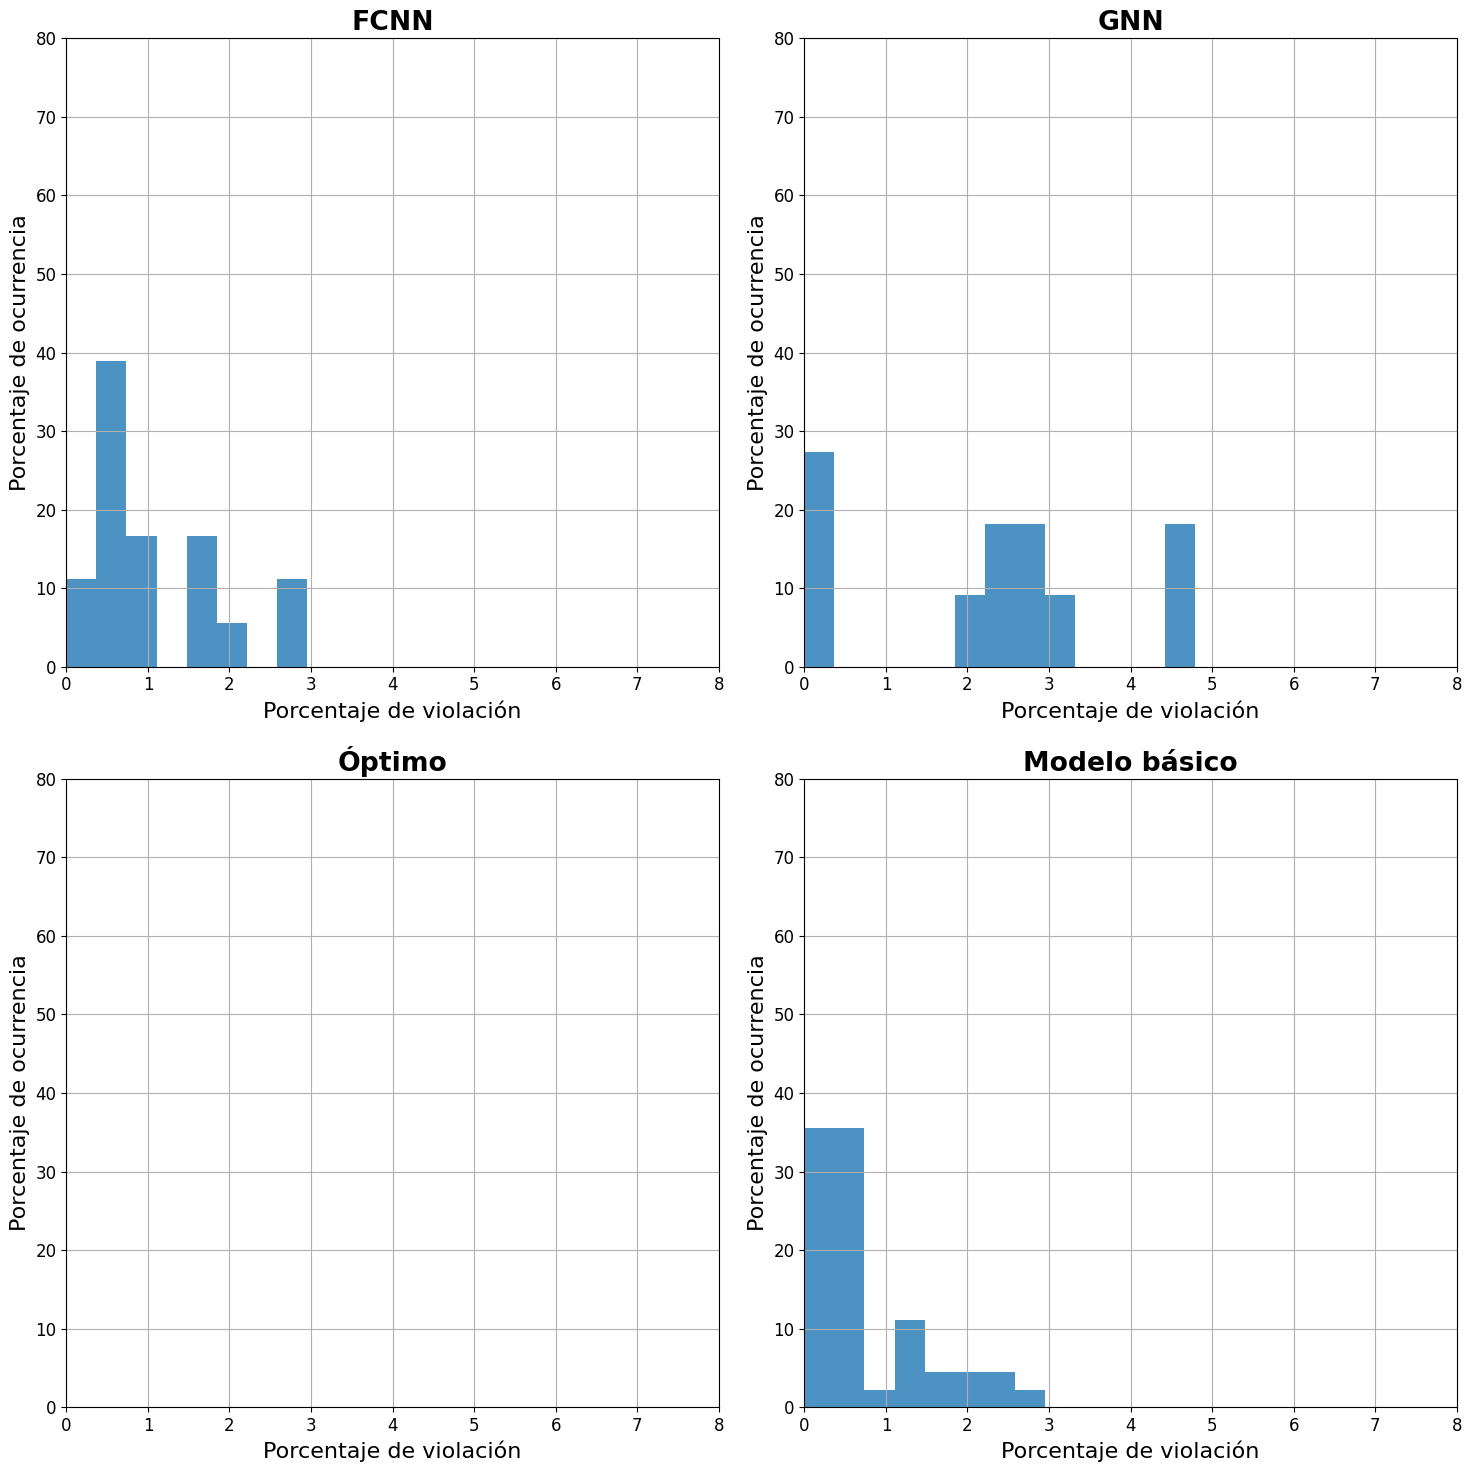

In [127]:

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({ 'xtick.labelsize': 12,'ytick.labelsize': 12})

bins = np.linspace(0, 7, 20)  # Creates 10 bins from 0 to 10

fig, axs = plt.subplots(2, 2, figsize=(15, 15))


x_limits = (0, 8)
y_limits = (0, 80)

# Plot the normalized histogram for pred FCNN
axs[0,0].set_title("FCNN", fontweight='bold')
axs[0,0].hist(gap_percentages_hist_FCNN, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_FCNN) / len(gap_percentages_hist_FCNN) * 100)  
axs[0,0].set_xlabel("Porcentaje de violación")
axs[0,0].set_ylabel("Porcentaje de ocurrencia")
axs[0,0].set_xlim(x_limits)
axs[0,0].set_ylim(y_limits)
axs[0,0].tick_params(axis='both', which='major')
axs[0,0].grid()

# Plot the normalized histogram for pred GNN
axs[0,1].set_title("GNN", fontweight='bold')
axs[0,1].hist(gap_percentages_hist_GNN, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_GNN) / len(gap_percentages_hist_GNN) * 100) 
axs[0,1].set_xlabel("Porcentaje de violación")
axs[0,1].set_ylabel("Porcentaje de ocurrencia")
axs[0,1].set_xlim(x_limits)
axs[0,1].set_ylim(y_limits)
axs[0,1].tick_params(axis='both', which='major')
axs[0,1].grid()

# Plot the normalized histogram for opt
axs[1,0].set_title("Óptimo", fontweight='bold')
axs[1,0].hist(gap_percentages_hist_opt, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_opt) / len(gap_percentages_hist_opt) * 100)  
axs[1,0].set_xlabel("Porcentaje de violación")
axs[1,0].set_ylabel("Porcentaje de ocurrencia")
axs[1,0].set_xlim(x_limits)
axs[1,0].set_ylim(y_limits)
axs[1,0].tick_params(axis='both', which='major')
axs[1,0].grid()

# Plot the normalized histogram for v1
axs[1,1].set_title("Modelo básico", fontweight='bold')
axs[1,1].hist(gap_percentages_hist_v1, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_v1) / len(gap_percentages_hist_v1) * 100)  
axs[1,1].set_xlabel("Porcentaje de violación")
axs[1,1].set_ylabel("Porcentaje de ocurrencia")
axs[1,1].set_xlim(x_limits)
axs[1,1].set_ylim(y_limits)
axs[1,1].tick_params(axis='both', which='major')
axs[1,1].grid()

plt.tight_layout()
plt.show()
fig.savefig(f"./figs/gaps_{red}_sintetica.pdf")

## ANALISIS TIEMPO

In [29]:
import time 

ts = []
for x,y in test_loader:
    for dato in x:
        t_0 = time.time()
        _ = model(dato.unsqueeze(0), training=False, denormalize_y=cfg.data.normalize_Y).detach().cpu().numpy()
        t_f = time.time()
        ts.append(t_f-t_0)

print(f"El tiempo por dato promedio para {arq}/IEEE{red} es {np.mean(ts)}")

El tiempo por dato promedio para GNN_local/IEEEuru es 0.0034338094381042954


In [30]:
import time 

ts = []
t_0 = time.time()
for x,y in test_loader:
        _ = model(x, training=False, denormalize_y=cfg.data.normalize_Y).detach().cpu().numpy()
t_f = time.time()

print(f"El tiempo para todo el conjunto de test es de {t_f-t_0}")

El tiempo para todo el conjunto de test es de 0.10569477081298828


In [33]:
import time 
ts = []
net.line["pm_param/target_branch"] = True
pp.runpm_ploss(net)
for idx in range(np.shape(x_tot)[0]):
    t_0 = time.time()
    net.load.loc[:,'p_mw'] = x_tot[idx,idx_load,0]
    net.load.loc[:,'q_mvar'] = x_tot[idx,idx_load,1]
    net.gen.loc[:,'p_mw'] =  x_tot[idx,idx_gens,2]
    pp.runpm_ploss(net)
    t_f = time.time()
    ts.append(t_f-t_0)
    
print(f"El tiempo para el IPOPT para cada dato es {np.mean(ts)}")
print(f"El tiempo para el IPOPT para el conjunto de test es {np.sum(ts)}")

array([0.0051949 , 0.00043774, 0.00033855, ..., 0.00024271, 0.00024223,
       0.00024199])